In [1]:
!pip install pandas


### Imports and Setup

In [5]:
import sqlite3
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

pd.set_option('display.max_columns', None)


### Show Tables in Databases

In [6]:
def show_tables(db_path, name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables in {name} DB:")
    for t in tables:
        print("-", t[0])
    conn.close()

# Check tables in both databases
show_tables("/kaggle/input/modelset/modelset-dataset-master/datasets/dataset.ecore/data/ecore.db", "Ecore")
show_tables("/kaggle/input/modelset/modelset-dataset-master/datasets/dataset.genmymodel/data/genmymodel.db", "GenMyModel")


Tables in Ecore DB:
- models
- metadata
- repositories
- clusters
- sqlite_sequence
- clusters_models
- sessions
- events
Tables in GenMyModel DB:
- models
- metadata
- repositories
- clusters
- sqlite_sequence
- clusters_models
- events


### Dataset Loader

In [20]:
def load_modelset(db_path, name):
    conn = sqlite3.connect(db_path)
    
    models_df = pd.read_sql("SELECT * FROM models", conn)
    metadata_df = pd.read_sql("SELECT * FROM metadata", conn)
    merged_df = pd.merge(models_df, metadata_df, on="id", how="left")
    
    if 'json' in merged_df.columns:
        try:
            merged_df['json'] = merged_df['json'].apply(lambda x: json.loads(x) if pd.notnull(x) else {})
        except Exception as e:
            print(f"[{name}] JSON parse error: {e}")
    
    conn.close()
    return merged_df

# Load datasets and print immediately
ecore_data = load_modelset("/kaggle/input/modelset/modelset-dataset-master/datasets/dataset.ecore/data/ecore.db", "Ecore")
print(f"\n Ecore Dataset Loaded")
display(ecore_data.head(2))
print(f"Total entries: {len(ecore_data)}")

genmymodel_data = load_modelset("/kaggle/input/modelset/modelset-dataset-master/datasets/dataset.genmymodel/data/genmymodel.db", "GenMyModel")
print(f"\n GenMyModel Dataset Loaded")
display(genmymodel_data.head(2))
print(f"Total entries: {len(genmymodel_data)}")



 Ecore Dataset Loaded


,id,repo,filename,metadata,json
0,repo-ecore-all/data/mde-optimiser/comma-18-map...,repo-ecore-all,data/mde-optimiser/comma-18-mapg/results/exper...,category: arguments,{'category': ['arguments']}
1,repo-ecore-all/data/hoycdanny/MyGithub/imac-pr...,repo-ecore-all,data/hoycdanny/MyGithub/imac-project/OpenDDS/O...,,{}


Total entries: 17694

 GenMyModel Dataset Loaded


,id,repo,filename,metadata,json
0,repo-genmymodel-uml/data/_WJKFoOBcEeeAyLDAJ12_...,repo-genmymodel-uml,data/_WJKFoOBcEeeAyLDAJ12_fg.xmi,"category: computer-ui, comment: ""seems to mode...","{'domain': ['computer'], 'subdomain': ['ui'], ..."
1,repo-genmymodel-uml/data/_grOBAOs7EeiJfugOH9Y5...,repo-genmymodel-uml,data/_grOBAOs7EeiJfugOH9Y5Zg.xmi,"category: computer-videogames, comment: ""model...","{'domain': ['computer'], 'subdomain': ['videog..."


Total entries: 57676


### Preprocessing

In [21]:
def encode_categorical(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            df[column] = label_encoder.fit_transform(df[column].astype(str))
    return df

def normalize_numerical(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

def handle_missing_values(df, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))
    return df

def preprocess_dataset(df, impute_strategy='mean'):
    df = encode_categorical(df)
    df = normalize_numerical(df)
    df = handle_missing_values(df, strategy=impute_strategy)
    return df

# Preprocess datasets and print some info immediately
ecore_data = preprocess_dataset(ecore_data)
print("\n Ecore Dataset Preprocessed")
display(ecore_data.head(2))

genmymodel_data = preprocess_dataset(genmymodel_data)
print("\n GenMyModel Dataset Preprocessed")
display(genmymodel_data.head(2))



 Ecore Dataset Preprocessed


,id,repo,filename,metadata,json
0,0.275081,-1.0,0.275081,-0.686747,-0.765273
1,0.037133,-1.0,0.037133,-1.000000,1.000000



 GenMyModel Dataset Preprocessed


,id,repo,filename,metadata,json
0,0.080156,-1.0,0.080156,0.365566,0.367925
1,0.366207,-1.0,0.366207,0.391509,0.389151


### Isolation Forest Outlier Detection

In [22]:
def identify_outliers(df):
    iso_forest = IsolationForest(n_estimators=100, max_samples=100, random_state=42)
    iso_forest.fit(df)
    scores = iso_forest.decision_function(df)
    labels = iso_forest.predict(df)
    df['Anomaly_Score'] = scores
    df['Label'] = labels  # 1 = normal, -1 = anomaly
    return df

# Detect outliers and print counts immediately
ecore_data = identify_outliers(ecore_data)
spurious_count_ecore = (ecore_data['Label'] == -1).sum()
print(f"\n✅ Outliers detected in Ecore dataset: {spurious_count_ecore} anomalous entries")

genmymodel_data = identify_outliers(genmymodel_data)
spurious_count_gen = (genmymodel_data['Label'] == -1).sum()
print(f"✅ Outliers detected in GenMyModel dataset: {spurious_count_gen} anomalous entries")



✅ Outliers detected in Ecore dataset: 6405 anomalous entries
✅ Outliers detected in GenMyModel dataset: 10581 anomalous entries


###  Display Spurious & Normal Counts 

In [23]:
def display_spurious_normal_categories(df):
    spurious_count = df[df['Label'] == -1].shape[0]
    normal_count = df[df['Label'] == 1].shape[0]
    
    result_df = pd.DataFrame({'Category': ['Spurious Models', 'Normal Models'],
                              'Count': [spurious_count, normal_count]})
    return result_df.style.bar(subset=['Count'], color='#d65f5f')

print("\nSpurious and Normal Model Counts for Ecore Dataset:")
display(display_spurious_normal_categories(ecore_data))

print("\nSpurious and Normal Model Counts for GenMyModel Dataset:")
display(display_spurious_normal_categories(genmymodel_data))



Spurious and Normal Model Counts for Ecore Dataset:


,Category,Count
0,Spurious Models,6405
1,Normal Models,11289



Spurious and Normal Model Counts for GenMyModel Dataset:


,Category,Count
0,Spurious Models,10581
1,Normal Models,47095


### PCA Visualization 

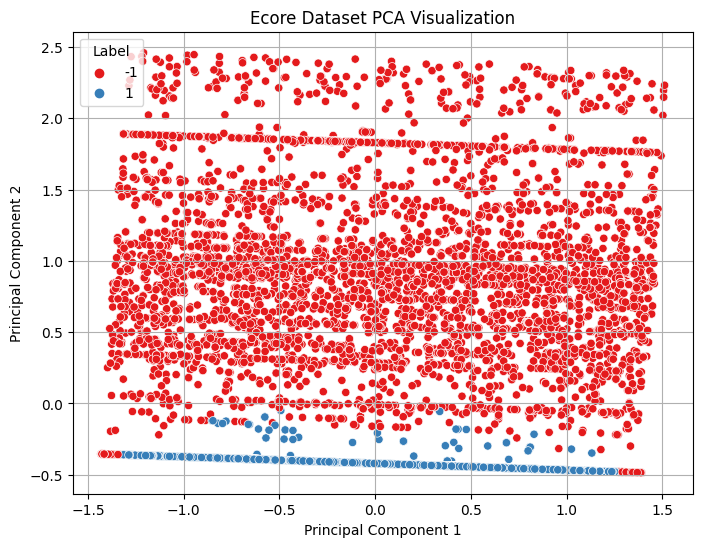

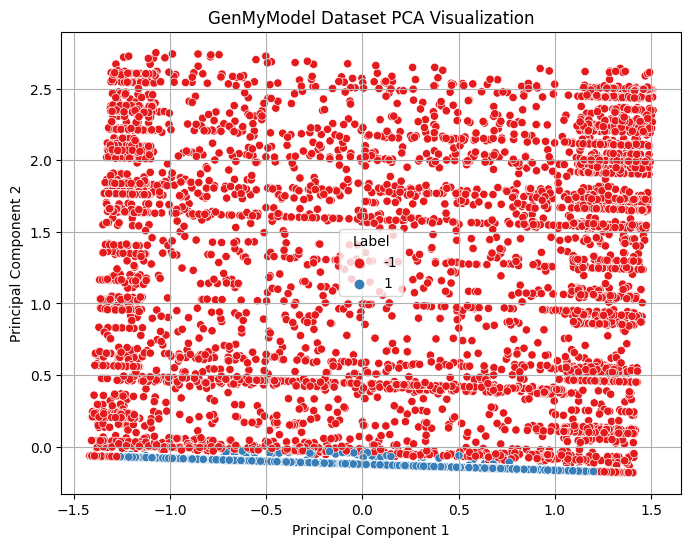

In [24]:
def visualize_with_pca(df, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(columns=['Anomaly_Score', 'Label']))
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Label'], palette='Set1')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Label')
    plt.grid(True)
    plt.show()

# Visualize PCA in respective cells with plots right after
visualize_with_pca(ecore_data, "Ecore Dataset PCA Visualization")
visualize_with_pca(genmymodel_data, "GenMyModel Dataset PCA Visualization")


### Isolation Forest Evaluation

In [25]:
def evaluate_model_cv_with_metrics(df, dataset_name):
    X = df.drop(columns=['Anomaly_Score', 'Label'])
    y = df['Label']
    
    iso_forest = IsolationForest(n_estimators=100, max_samples=100, random_state=42)
    
    accuracy_scores = cross_val_score(iso_forest, X, y, cv=10, scoring='accuracy')
    precision_scores = cross_val_score(iso_forest, X, y, cv=10, scoring='precision')
    recall_scores = cross_val_score(iso_forest, X, y, cv=10, scoring='recall')
    f1_scores = cross_val_score(iso_forest, X, y, cv=10, scoring='f1')
    
    result_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Score': [np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)]
    })
    
    print(f"\n📊 Evaluation Results for {dataset_name}:")
    print(tabulate(result_df, headers='keys', tablefmt='pretty'))

# Run evaluation and print results right away
evaluate_model_cv_with_metrics(ecore_data, "Ecore")
evaluate_model_cv_with_metrics(genmymodel_data, "GenMyModel")



📊 Evaluation Results for Ecore:
+---+-----------+--------------------+
|   |  Metric   |       Score        |
+---+-----------+--------------------+
| 0 | Accuracy  | 0.9807278841823879 |
| 1 | Precision | 0.9994452780407306 |
| 2 |  Recall   | 0.9702223348853118 |
| 3 | F1-score  | 0.9845777245188403 |
+---+-----------+--------------------+

📊 Evaluation Results for GenMyModel:
+---+-----------+--------------------+
|   |  Metric   |       Score        |
+---+-----------+--------------------+
| 0 | Accuracy  | 0.9896317905429213 |
| 1 | Precision | 0.9881053870229712 |
| 2 |  Recall   | 0.9993429174804703 |
| 3 | F1-score  | 0.9936846366517449 |
+---+-----------+--------------------+


### Autoencoder Anomaly Detection and Evaluation

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from tabulate import tabulate

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder with Dropout
    encoder = Dense(64, activation='relu',
                    activity_regularizer=regularizers.l1(1e-5))(input_layer)
    encoder = Dropout(0.3)(encoder)  # dropout 30%
    encoder = Dense(32, activation='relu')(encoder)
    encoder = Dropout(0.3)(encoder)
    encoder = Dense(16, activation='relu')(encoder)
    
    # Decoder with Dropout
    decoder = Dense(32, activation='relu')(encoder)
    decoder = Dropout(0.3)(decoder)
    decoder = Dense(64, activation='relu')(decoder)
    decoder = Dropout(0.3)(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)  # output bounded [0,1]
    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

def evaluate_autoencoder(df, dataset_name, threshold_percentile=25):
    X = df.drop(columns=['Anomaly_Score', 'Label']).values
    y_true = df['Label'].values
    
    autoencoder = build_autoencoder(X.shape[1])
    autoencoder.fit(X, X, epochs=50, batch_size=32, verbose=0)  # increased epochs for better training
    
    X_pred = autoencoder.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=1)
    
    threshold = np.percentile(mse, threshold_percentile)
    ae_labels = np.where(mse >= threshold, -1, 1)
    
    acc = accuracy_score(y_true, ae_labels)
    prec = precision_score(y_true, ae_labels, pos_label=-1)
    rec = recall_score(y_true, ae_labels, pos_label=-1)
    f1 = f1_score(y_true, ae_labels, pos_label=-1)

    results = {
        'Model': 'Autoencoder',
        'Accuracy': round(acc * 100, 2),
        'Precision': round(prec * 100, 2),
        'Recall': round(rec * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    result_df = pd.DataFrame([results])
    print(f"\n📊 Autoencoder Anomaly Detection Results for {dataset_name}:")
    print(tabulate(result_df, headers='keys', tablefmt='pretty'))

# Run on both datasets
evaluate_autoencoder(ecore_data, "Ecore")
evaluate_autoencoder(genmymodel_data, "GenMyModel")


553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Autoencoder Anomaly Detection Results for Ecore:
+---+-------------+----------+-----------+--------+----------+
|   |    Model    | Accuracy | Precision | Recall | F1-score |
+---+-------------+----------+-----------+--------+----------+
| 0 | Autoencoder |  57.01   |   45.47   | 94.21  |  61.34   |
+---+-------------+----------+-----------+--------+----------+
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

📊 Autoencoder Anomaly Detection Results for GenMyModel:
+---+-------------+----------+-----------+--------+----------+
|   |    Model    | Accuracy | Precision | Recall | F1-score |
+---+-------------+----------+-----------+--------+----------+
| 0 | Autoencoder |  42.78   |   24.09   | 98.47  |  38.71   |
+---+-------------+----------+-----------+--------+----------+
